In [35]:
import pandas as pd

In [36]:
data = pd.read_csv(r".\digit recognizor.csv")

In [37]:
X = data.iloc[:,1:]
y = data.iloc[:,0]
X.shape

(42000, 784)

## 方差过滤

In [38]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()                      #实例化，不填参数默认方差为0
X_var0 = selector.fit_transform(X)                  #获取删除不合格特征之后的新特征矩阵
X_var0.shape                                        #(42000, 708)
pd.DataFrame(X_var0).head()

,0,1,2,3,4,5,6,7,8,9,...,698,699,700,701,702,703,704,705,706,707
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
import numpy as np
X_fsvar = VarianceThreshold(np.median(X.var().values)).fit_transform(X)
X_fsvar.shape                 

(42000, 392)

## 卡方过滤

In [40]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

chivalue, pvalues_chi = chi2(X_fsvar, y)
#k取多少？我们想要消除所有p值大于设定值，比如0.05或0.01的特征：
k_ = chivalue.shape[0] - (pvalues_chi > 0.05).sum()
X_fschi = SelectKBest(chi2, k=k_).fit_transform(X_fsvar, y)
X_fschi.shape

(42000, 392)

In [41]:
cross_val_score(RFC(n_estimators=10, random_state=0), X_fschi, y, cv=5).mean()

0.9390476190476191

## F检验

In [42]:
from sklearn.feature_selection import f_classif
F, pvalues_f = f_classif(X_fsvar,y)
k_ = F.shape[0] - (pvalues_f > 0.05).sum()
X_fsF = SelectKBest(f_classif, k=k_).fit_transform(X_fsvar, y)
X_fsF.shape

(42000, 392)

In [43]:
cross_val_score(RFC(n_estimators=10,random_state=0),X_fsF,y,cv=5).mean()

0.9390476190476191

## 互信息法

In [44]:
from sklearn.feature_selection import mutual_info_classif as MIC
result = MIC(X_fsvar, y)
k_ = result.shape[0] - sum(result <= 0)
 
X_fsmic = SelectKBest(MIC, k=k_).fit_transform(X_fsvar, y)

In [45]:
cross_val_score(RFC(n_estimators=10, random_state=0), X_fsmic, y, cv=5).mean()

0.9390476190476191

## 嵌入法

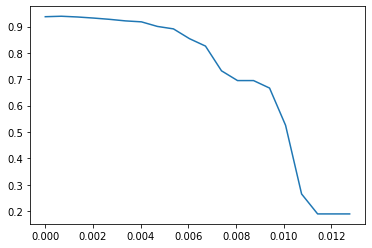

In [46]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RFC
 
RFC_ = RFC(n_estimators =10, random_state=0)

#同样的，我们也可以画学习曲线来找最佳阈值
#======【TIME WARNING：10 mins】======#
import numpy as np
import matplotlib.pyplot as plt
 
RFC_.fit(X, y).feature_importances_
threshold = np.linspace(0, (RFC_.fit(X,y).feature_importances_).max(), 20)
 
score = []
for i in threshold:
    X_embedded = SelectFromModel(RFC_, threshold=i).fit_transform(X, y)
    once = cross_val_score(RFC_, X_embedded, y, cv=5).mean()
    score.append(once)
plt.plot(threshold, score)
plt.show()

In [47]:
X_embedded = SelectFromModel(RFC_,threshold=0.00067).fit_transform(X,y)
display(X_embedded.shape)
cross_val_score(RFC_, X_embedded, y, cv=5).mean()

(42000, 324)

0.9391190476190475

### 在第一条学习曲线后选定一个范围，使用细化的学习曲线来找到最佳值

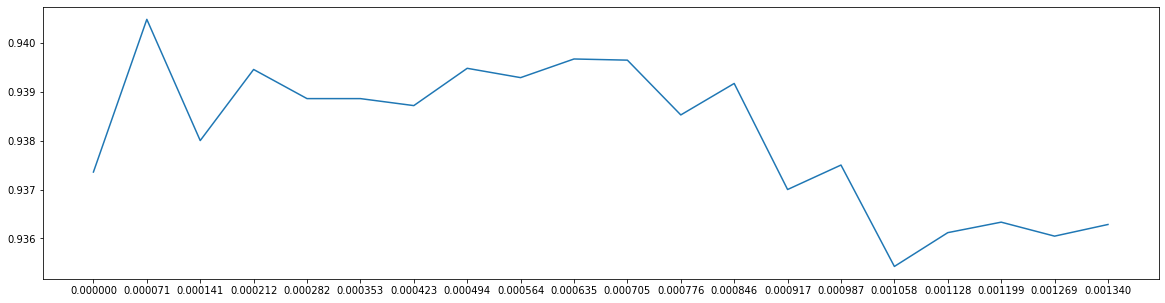

In [48]:
score2 = []
for i in np.linspace(0, 0.00134, 20):
    X_embedded = SelectFromModel(RFC_, threshold=i).fit_transform(X, y)
    once = cross_val_score(RFC_, X_embedded, y, cv=5).mean()
    score2.append(once)
plt.figure(figsize=[20, 5])
plt.plot(np.linspace(0, 0.00134, 20), score2)
plt.xticks(np.linspace(0, 0.00134, 20))
plt.show()

In [49]:
X_embedded = SelectFromModel(RFC_,threshold=0.000564).fit_transform(X,y)
display(X_embedded.shape)
display(cross_val_score(RFC_,X_embedded,y,cv=5).mean())

(42000, 340)

0.9392857142857144

In [50]:
 #=====【TIME WARNING：2 min】=====#
#我们可能已经找到了现有模型下的最佳结果，如果我们调整一下随机森林的参数呢？
cross_val_score(RFC(n_estimators=100, random_state=0), X_embedded, y, cv=5).mean()

0.9634285714285715

## 包装法

In [51]:
from sklearn.feature_selection import RFE
RFC_ = RFC(n_estimators =10,random_state=0)
selector = RFE(RFC_, n_features_to_select=340, step=50).fit(X, y)

In [52]:
selector.support_.sum() #340

340

In [53]:
selector.ranking_

array([10,  9,  8,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  6,  6,
        5,  6,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  6,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  6,  6,  5,  4,
        4,  5,  3,  4,  4,  4,  5,  4,  5,  7,  6,  7,  7,  7,  8,  8,  8,
        8,  8,  8,  8,  8,  6,  7,  4,  3,  1,  2,  3,  3,  1,  1,  1,  1,
        1,  3,  3,  4,  5,  5,  5,  8,  8,  9,  9,  9,  9,  8,  9,  9,  4,
        4,  3,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  3,  3,  4,
        5,  5,  9,  9, 10, 10, 10, 10,  7,  4,  4,  3,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  3,  3,  5,  8, 10, 10, 10,
       10,  9,  4,  4,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  3,  4, 10, 10, 10, 10,  9,  7,  4,  3,  2,  2,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
        4,  4, 10,  9, 10

In [54]:
X_wrapper = selector.transform(X)
cross_val_score(RFC_, X_wrapper, y, cv=5).mean()

0.9379761904761905

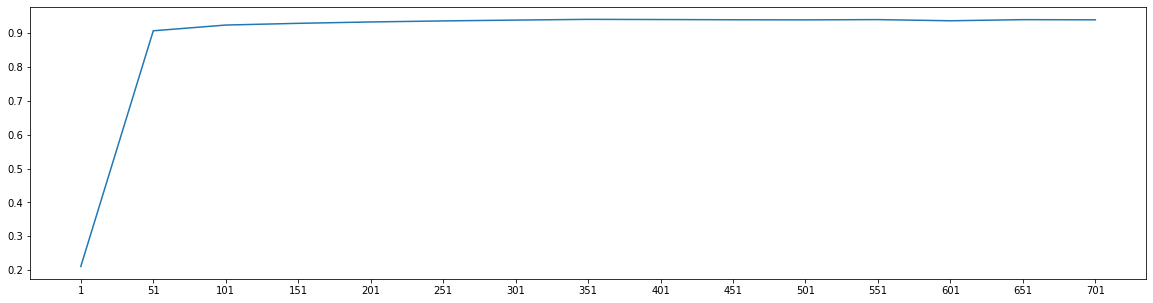

In [55]:
#======【TIME WARNING: 15 mins】======#
score = []
for i in range(1, 751, 50):
    X_wrapper = RFE(RFC_, n_features_to_select=i, step=50).fit_transform(X, y)
    once = cross_val_score(RFC_, X_wrapper, y, cv=5).mean()
    score.append(once)
plt.figure(figsize=[20, 5])
plt.plot(range(1, 751, 50), score)
plt.xticks(range(1, 751, 50))
plt.show()